In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import datacube

dc = datacube.Datacube(app='fmc-snippet')

### Request some sentinel 2 data

In [2]:
query = {
        'lat': (-35.27, -35.33),
        'lon': (149.07, 149.15),
        'output_crs': 'EPSG:3577',
        'resolution': (-20, 20),
        'time': ('2017-01-01', '2017-02-01'),
        'measurements': ["nbar_blue","nbar_green","nbar_red",
                         "nbar_nir_1","nbar_nir_2","nbar_swir_2",
                         "nbar_swir_3"]
        }

cbr = dc.load(product='s2a_ard_granule', group_by='solar_day', **query)
cbr

<xarray.Dataset>
Dimensions:      (time: 2, x: 405, y: 380)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-05T00:02:12.026000 2017-01-15T00:02:11.026000
  * y            (y) float64 -3.956e+06 -3.956e+06 ... -3.963e+06 -3.963e+06
  * x            (x) float64 1.544e+06 1.544e+06 ... 1.552e+06 1.553e+06
Data variables:
    nbar_blue    (time, y, x) int16 903 863 858 824 804 ... 385 423 480 300 279
    nbar_green   (time, y, x) int16 1051 1029 1013 987 979 ... 543 591 467 412
    nbar_red     (time, y, x) int16 1301 1269 1249 1177 1164 ... 576 618 343 367
    nbar_nir_1   (time, y, x) int16 2456 2350 2423 2411 ... 1550 1915 3377 2475
    nbar_nir_2   (time, y, x) int16 2658 2536 2533 2566 ... 1848 2198 3281 3346
    nbar_swir_2  (time, y, x) int16 2862 2780 2707 2671 ... 1490 1387 1525 1585
    nbar_swir_3  (time, y, x) int16 1817 1732 1675 1644 1643 ... 930 846 826 761
Attributes:
    crs:      EPSG:3577

### These are the two aux functions where all the magic happens (optimisations should come here I imagine)

In [3]:
def get_fmc_functor():
    # Load FMC table
    fmc = np.load("./FMC.npy")
    
    def get_fmc(idxs, fmc=fmc):
        # Select Veg type subset from LUT table
        mean = np.einsum('i->', fmc[idxs])/idxs.shape[0]
        return mean, np.sqrt(np.einsum('i->',(fmc[idxs]-mean)**2)/idxs.shape[0])

    return get_fmc


def get_top_n_functor():
    # Read the LUT table
    lut = np.load("./LUT.npy")
    lut = lut[:, [0,1,2,3,5,6,7]]

    lut_sq = np.sqrt(np.einsum('ij,ij->i',lut, lut))

    def get_top_n(mb, veg_type, top_n, mat=lut, smat=lut_sq):
        
        #Vegetation type mocked to type 1
        #idx = get_vegtype_idx(veg_type)
        idx = (0, 2563)

        # Select Veg type subset from LUT table
        vmat = mat[idx[0]:idx[1], :]
        vsmat = smat[idx[0]:idx[1]]

        # This is a computational trick that results in a +2x speedup of the code
        # arccos is a decreaing function in the [-1,1] range so we can replace this
        # with a constant linear function as we are only interested in the relative values.
        #err = np.arccos(np.einsum('ij,j->i', vmat, mb)/(np.einsum('i,i->', mb, mb)**.5*vsmat))
        #err = -1*np.einsum('ij,j->i', vmat, mb)/(np.einsum('i,i->', mb, mb)**.5*vsmat)
        err = np.einsum('ij,j->i', vmat, mb)

        idxs = np.argpartition(err, top_n)[:top_n] + idx[0]

        return idxs

    return get_top_n

### This is the actual function that iterates through each pixel on a multispectral cube and computes the Fuel Moisture Content values

In [4]:
def fmc(raster_stack, q_mask, veg_type):
    ndvi_raster = ((raster_stack[:, :, 3]-raster_stack[:, :, 2])/(raster_stack[:, :, 3]+raster_stack[:, :, 2])).values
    raster_stack = raster_stack.values
    # In case the mask doesn't exist
    if q_mask is None:
        q_mask = np.ones((raster_stack.shape[0], raster_stack.shape[1]), dtype=bool)

    mean_arr = np.ones((raster_stack.shape[0], raster_stack.shape[1]), dtype=np.float32) * -9999.9
    std_arr = np.ones((raster_stack.shape[0], raster_stack.shape[1]), dtype=np.float32) * -9999.9
    
    get_top_n = get_top_n_functor()
    get_fmc = get_fmc_functor()
    
    for i in range(raster_stack.shape[1]):
        for j in range(raster_stack.shape[0]):
            #if veg_type[j, i] > 0 and ndvi_raster[j, i] > .15:
            if ndvi_raster[j, i] > .15:
                #top_40 = get_top_n(raster_stack[j, i, :], veg_type[j, i], 40)
                top_40 = get_top_n(raster_stack[j, i, :], 1, 40)
                mean_arr[j, i], std_arr[j, i] = get_fmc(top_40)

    return mean_arr, std_arr


### Here I'm just stacking variables in the XArray Dataset over the last axis

In [5]:

# stack variables
cbr = cbr[["nbar_blue","nbar_green","nbar_red",
     "nbar_nir_1","nbar_nir_2","nbar_swir_2",
     "nbar_swir_3"]].isel(time=1).to_array()

# move variable axis to last
cbr = np.swapaxes(cbr, 0, -1)

### Calling the function with our input Sentinel data. Notice Land Mask is None, we assume all pixels are classified as 1.

In [8]:
#%%timeit 

mean_arr, std_arr = fmc(cbr, None, None)

### Resulting mean and standard deviation values of the computed FMC array.

In [9]:
mean_arr.shape, std_arr.shape

((405, 380), (405, 380))

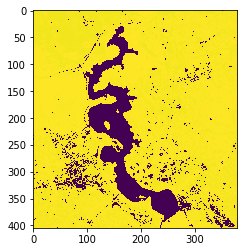

In [10]:
plt.imshow(mean_arr)